## 1. 데이터 로딩 및 전처리
이 단계에서는 yfinance 라이브러리를 사용해 Apple(AAPL)의 주가 데이터를 불러옵니다.

우리는 2022년 1월부터 2024년 1월까지의 데이터를 다운로드하며, 결측치를 제거하여 분석 가능한 형태로 정리합니다.

**yfinance**: Yahoo Finance에서 시계열 데이터를 손쉽게 가져올 수 있는 라이브러리

==== ticker 목록======

"AAPL": 애플

"GOOGL" : 구글

"MSFT" : 마이크로소프트

"AMZN" : 아마존

"TSLA" : 테슬라

"NVDA" : 엔비디아


아래 예시에서는 먼저 "**AAPL**"을 사용해보겠습니다

**start, end**: 조회할 날짜 범위 지정

**dropna()**: 결측값 제거

이 데이터를 기반으로 향후 주가 예측 모델을 구성할 예정입니다.



In [1]:
import yfinance as yf
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# ✅ 1. 데이터 로딩 및 전처리
ticker = "AAPL"          # Apple (미국)
df = yf.download(ticker, start="2022-01-01", end="2024-01-01").dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


### 불러온 차트가 어떻게 생겼는지 확인해 볼 수 있습니다!

**Close** : 종가 ( 장 마감 시 가격 )

**High** : 고가 ( 하루 중 가장 높은 가격 )

**Low** : 저가 ( 하루 중 가장 낮은 가격 )

**Open** : 시가 ( 장 시작 시 가격 )



In [2]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2022-01-03,178.645676,179.499605,174.425170,174.542947,104487900
2022-01-04,176.378311,179.558426,175.809030,179.254159,99310400
2022-01-05,171.686707,176.839663,171.411883,176.290017,94537600
2022-01-06,168.820694,172.059699,168.467348,169.507752,96904000
2022-01-07,168.987534,170.921120,167.868606,169.694226,86709100
...,...,...,...,...,...
2023-12-22,192.192551,193.989390,191.567126,193.761051,37122800
2023-12-26,191.646561,192.480450,191.428159,192.202487,28919300


### 📌 어떤 지표들을 가지고 주가를 예측할 수 있을까요?
주가에 영향을 미치는 요인은 매우 다양합니다.
시장 전체의 분위기, 경제 지표, 관련 뉴스, CEO의 발언이나 성향 등 외부적 요인이 큰 영향을 줄 수 있습니다.

그러나 이러한 비정형 데이터는 현재 사용 중인 데이터셋에 포함되어 있지 않으며, 모든 요소를 반영하려면 매우 복잡하고 대규모의 모델이 필요합니다.

이번 실습에서는 정형 데이터 기반의 단순한 예측 모델을 구성하기 위해 다음 두 가지 지표를 활용합니다:

**전일 대비 수익률 (Return)**: 오늘 종가가 전날 종가에 비해 얼마나 변했는지를 나타내는 비율

**20일 이동평균 (20-day Moving Average)**: 현재 시점을 기준으로, 과거 20일간의 종가

**20일 변동성 (20-day Volatility)** :  현재 시점을 기준으로, 과거 20일간의 종가의 표준편차

이 두 지표를 통해 일정 수준의 패턴을 추출하여 주가 예측을 시도해보겠습니다.



In [3]:
# ✅ 2. 기술적 지표 생성
df["Return_1"] = df["Close"].pct_change()                      # 전일 대비 수익률
df["MA_20"] = df["Close"].rolling(20).mean()                  # 20일 이동평균
df["Volatility_20"] = df["Close"].rolling(20).std()           # 20일 표준편차

### 무엇을 예측할까요?

결과값은 우리가 원하는 대로 결정할 수 있습니다.

1. 다음날의 Price( 종가 / 시가 / 고가 / 저가 등...)

2. 오늘 대비 내일의 상승률 (3% , -5% 등...)

3. 상승 여부 ( 이진 분류 - 오른다(1) , 내려간다(0) )

본 실습에서는 **다음날 종가 - 오늘 종가** 값을 예측하도록 하겠습니다

In [4]:
# ✅ 3. 타겟: 다음날 종가 - 오늘 종가 (회귀용 증가량)
df["Target"] = df["Close"].pct_change().shift(-1)
df = df.dropna()

In [5]:
df

Price,Close,High,Low,Open,Volume,Return_1,MA_20,Volatility_20,Target
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,
Date,,,,,,,,,
2022-01-31,171.549286,171.765221,166.376695,167.014689,115541600,0.026126,166.721706,6.635611,-0.000973
2022-02-01,171.382446,171.608191,169.124957,170.793531,86213900,-0.000973,166.358544,6.128016,0.007044
2022-02-02,172.589676,172.628945,170.126077,171.519828,84914300,0.007044,166.169112,5.854430,-0.016719
2022-02-03,169.704071,172.982345,168.938490,171.254868,89418100,-0.016719,166.069981,5.772294,-0.001680
2022-02-04,169.419022,171.099558,167.738485,168.721251,82465400,-0.001680,166.099897,5.788827,-0.004234
...,...,...,...,...,...,...,...,...,...
2023-12-21,193.264709,195.647271,192.093295,194.674400,46482500,-0.000770,192.080374,3.004390,-0.005548
2023-12-22,192.192551,193.989390,191.567126,193.761051,37122800,-0.005548,192.260555,2.889856,-0.002841


### 입력 변수(X)와 정답값(y) 생성
이 단계에서는 모델에 입력할 특징(feature)과 예측하고자 하는 정답값(target)을 정의하고, 정규화를 수행합니다.

**입력 변수(X)**

Return_1: 전일 대비 수익률

MA_20: 20일 이동평균

Volatility_20: 20일간의 표준편차 (변동성)

**정답값(y)**

Target: 다음날의 수익률 (예측 목표)

이후 모델 학습을 위해 StandardScaler를 사용하여 입력(X)과 정답(y)을 평균 0, 표준편차 1의 정규분포로 정규화합니다.
이 정규화 과정은 딥러닝 모델의 수렴 속도를 높이고, 성능을 안정화시키는 데 도움을 줍니다.

In [6]:
# ✅ 5. 입력(X)와 정답(y) 생성
features = ["Return_1", "MA_20", "Volatility_20"]
X = df[features].values
y = df["Target"].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

### 학습/테스트 데이터 분리 및 텐서 변환
**학습용 / 테스트용 데이터 분리**

전체 데이터의 80%를 학습(train), 20%를 테스트(test) 데이터로 사용합니다.

**PyTorch 텐서로 변환**

딥러닝 모델에서 학습할 수 있도록 NumPy 배열을 PyTorch 텐서로 변환합니다.


입력(X)은 정규화된 값을 사용하고,

정답(y)은 앞서 정규화된 y_scaled 값을 기반으로 분할된 시점에 맞게 나눠줍니다.


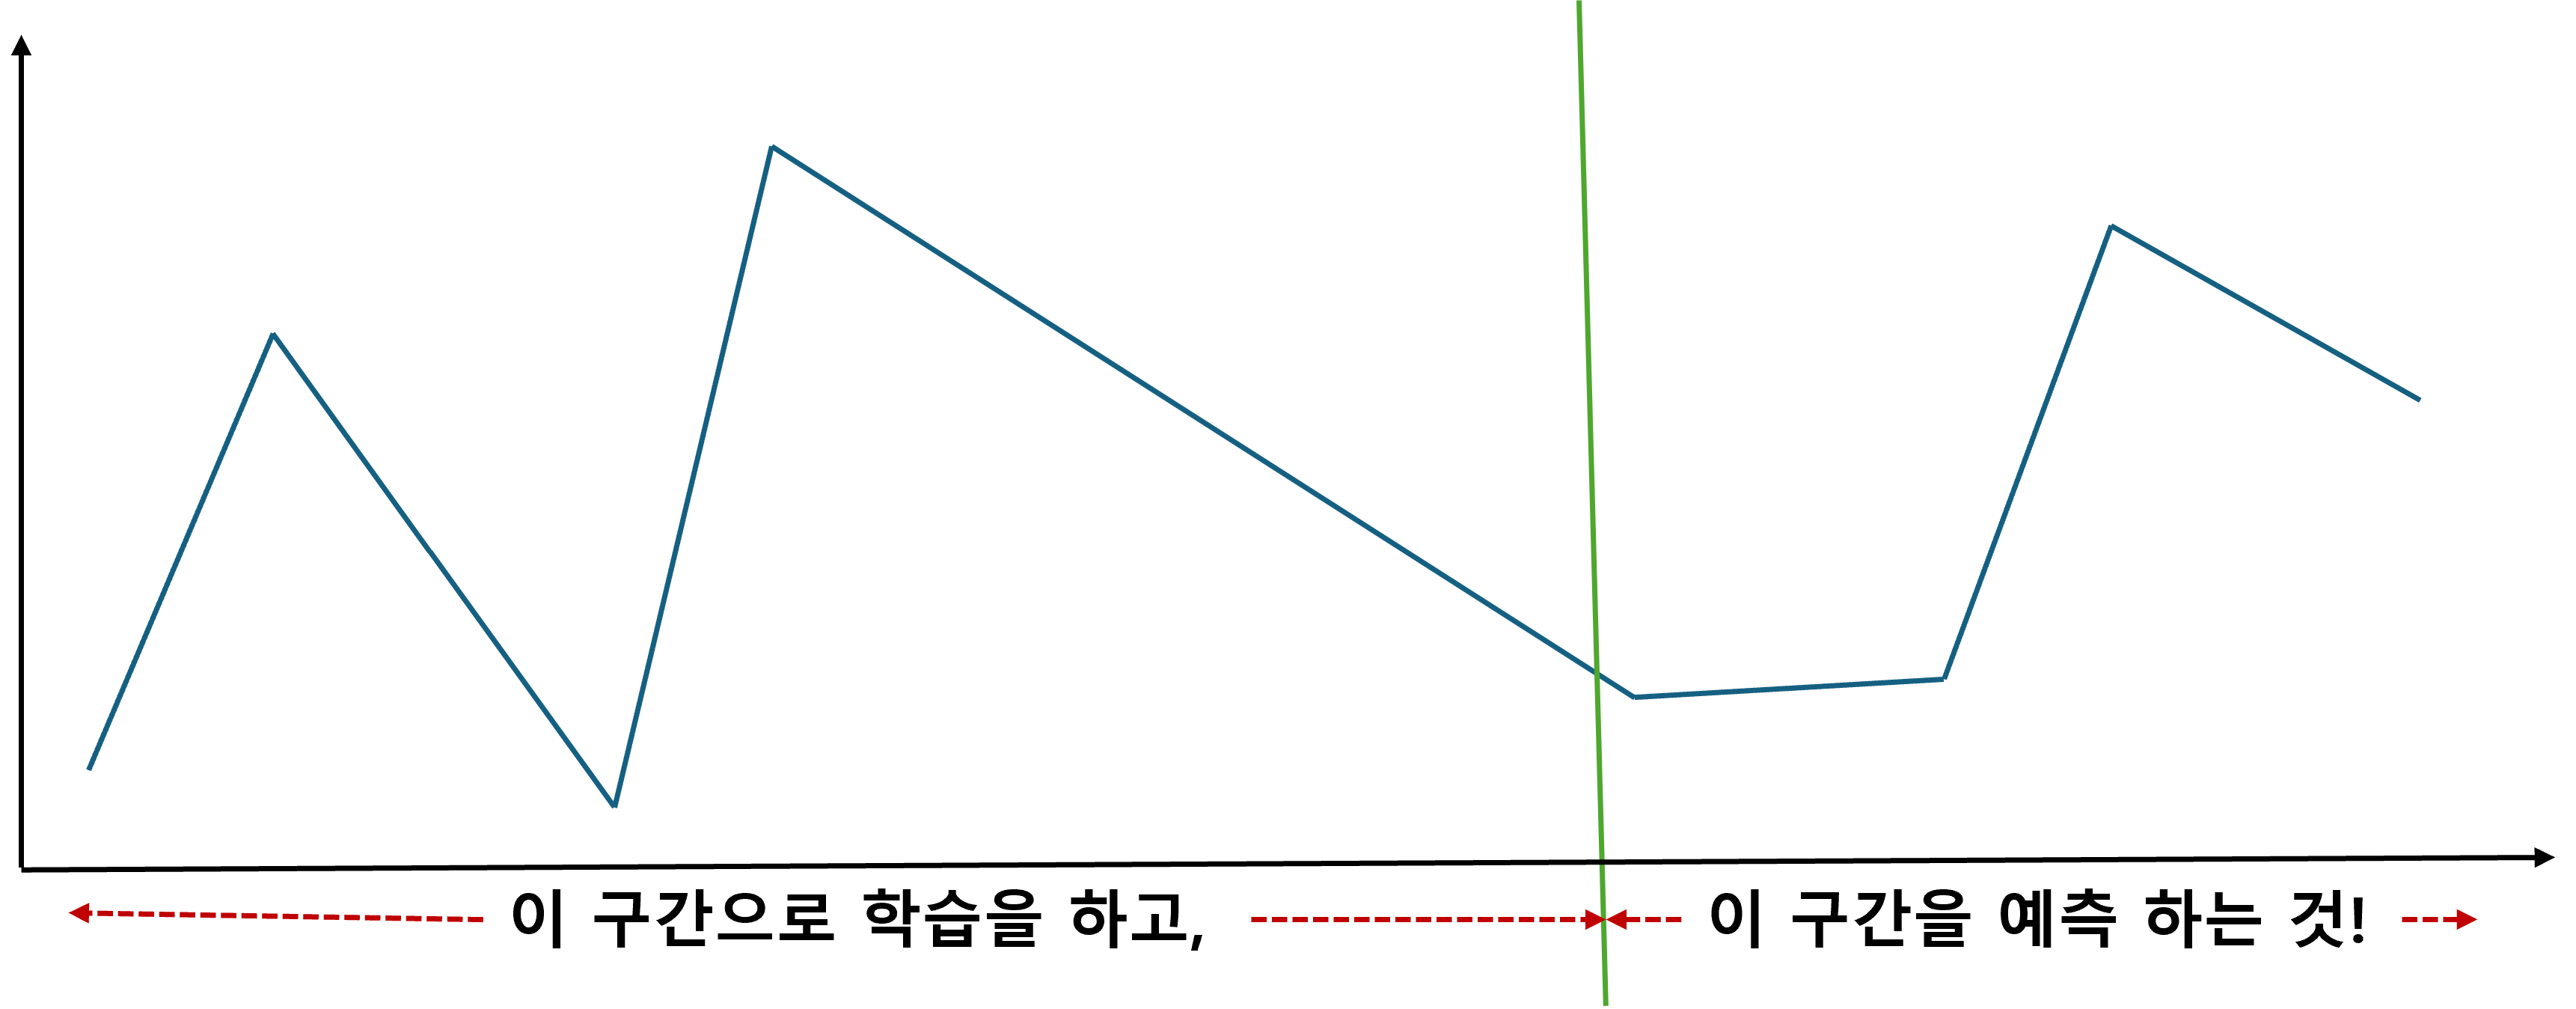





In [7]:
# ✅ 7. train/test 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

In [8]:
# ✅ 8. 텐서 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_scaled[:len(X_train)], dtype=torch.float32)
y_test = torch.tensor(y_scaled[len(X_train):], dtype=torch.float32)

## 9. PyTorch 기반 회귀 모델 정의
이제 PyTorch로 간단한 다층 퍼셉트론(Multi-Layer Perceptron, MLP) 구조의 회귀 모델을 정의합니다.

**입력값**은 3개 지표(Return_1, MA_20, Volatility_20), **출력**은 다음날 수익률(연속형 실수) 하나입니다.

###**주요 코드 설명**

nn.Linear(input_dim, 32)
→ 3차원 입력(3개 지표)을 받아 32차원으로 변환 (첫 번째 은닉층)

nn.ReLU()
→ 비선형성을 주기 위한 ReLU 함수 사용

nn.Linear(16, 1)
→ 마지막 출력은 예측할 수익률 하나, 따라서 출력 노드는 1개

forward() 함수
→ 학습/예측 시 실제 데이터가 통과하는 경로를 정의

model = StockRegressor(input_dim=3)
-> 우리는 3개의 input값 (3개의 지표)를 사용할 것이기에, input_dim은 3 입니다

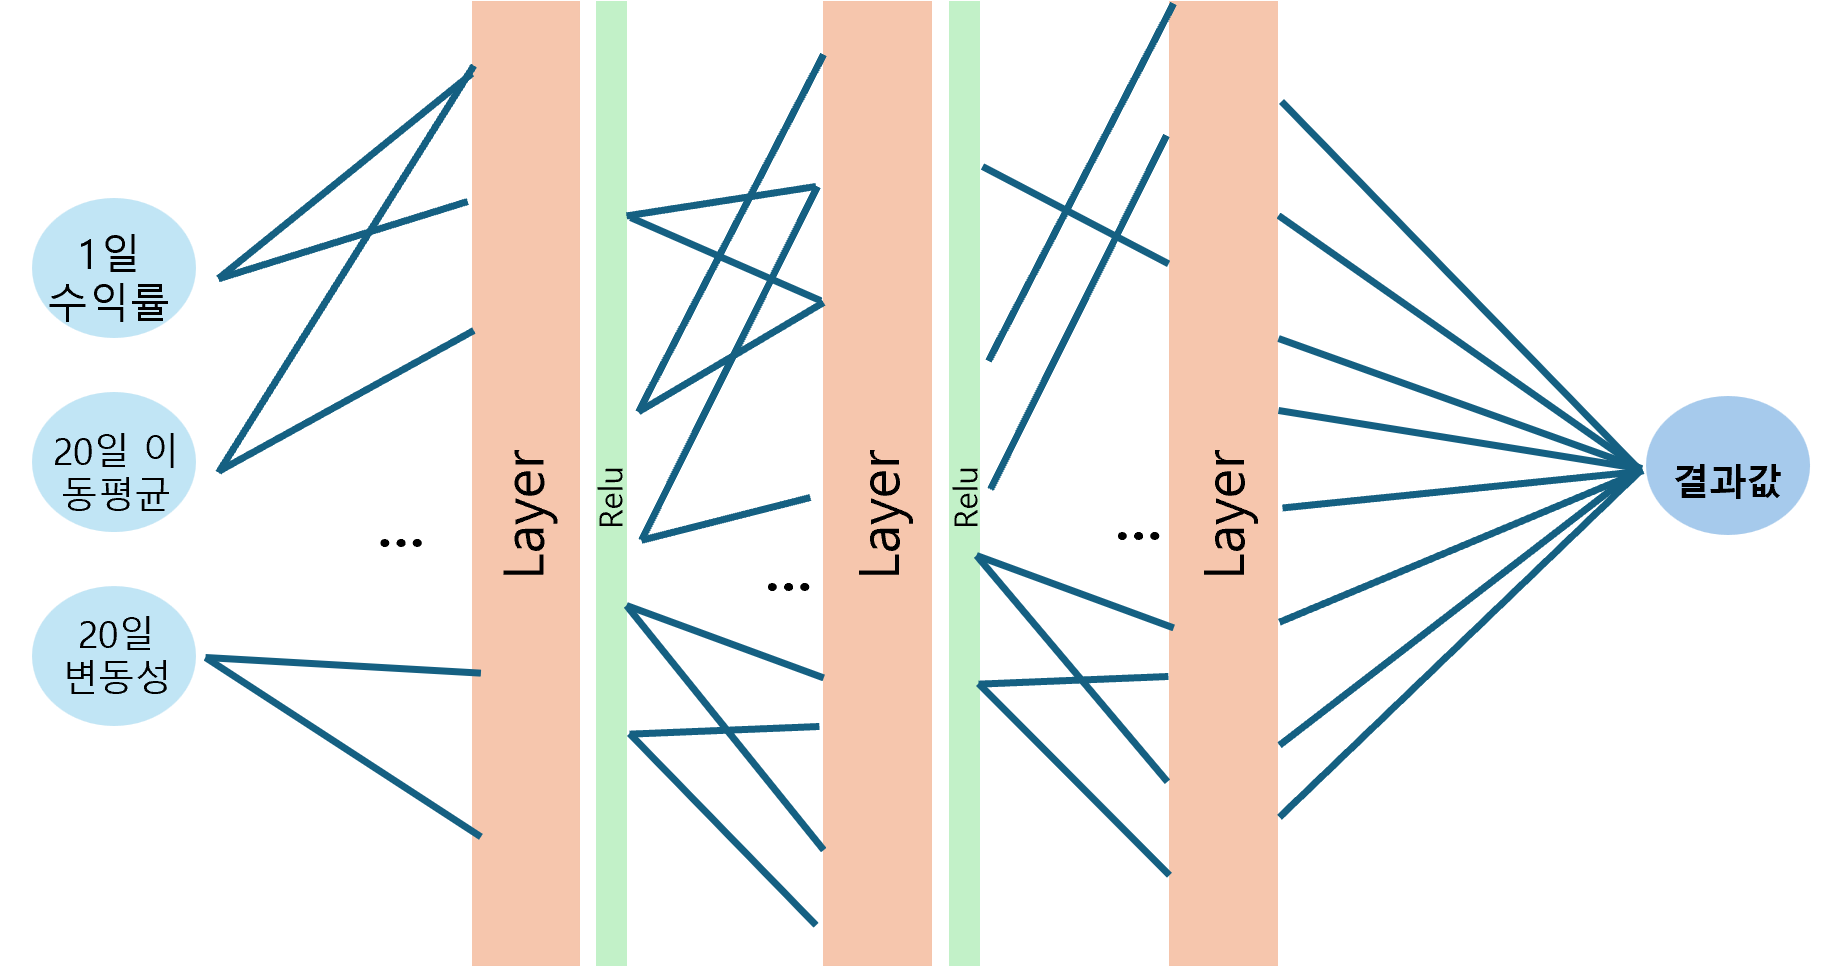


In [14]:
# ✅ 9. 회귀 모델 정의
class StockRegressor(nn.Module):
    def __init__(self, input_dim):
        super(StockRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # 회귀는 출력이 1개
        )

    def forward(self, x):
        return self.model(x)

model = StockRegressor(input_dim=3)

###학습 설정
모델을 학습시키기 위해 손실 함수와 최적화 알고리즘을 설정합니다.

**criterion** -> Regression에서 주로 사용되는 loss 함수

**epochs** -> 학습이 반복될 횟수

In [15]:
# ✅ 10. 학습 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
epochs = 100

In [16]:
# ✅ 11. 학습 루프
for epoch in range(epochs):
    model.train()
    preds = model(X_train)
    loss = criterion(preds, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {loss.item():.6f}")

Epoch [10/100] | Loss: 1.130019
Epoch [20/100] | Loss: 1.104605
Epoch [30/100] | Loss: 1.087499
Epoch [40/100] | Loss: 1.072166
Epoch [50/100] | Loss: 1.057868
Epoch [60/100] | Loss: 1.042707
Epoch [70/100] | Loss: 1.027655
Epoch [80/100] | Loss: 1.013505
Epoch [90/100] | Loss: 0.999960
Epoch [100/100] | Loss: 0.986930


### 모델 평가 (예측 및 성능 지표 계산)
모델 학습이 완료되면, 테스트 데이터를 활용하여 예측 성능을 평가합니다.

In [17]:
# ✅ 12. 평가
model.eval()
y_pred_scaled = model(X_test).detach().numpy()
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test.numpy())
with torch.no_grad():
    y_pred = model(X_test).numpy()
    y_true = y_test.numpy()

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)


    print(f"\n📊 MSE: {mse:.4f}")
    print(f"📊 MAE: {mae:.4f}")




📊 MSE: 0.5543
📊 MAE: 0.5881


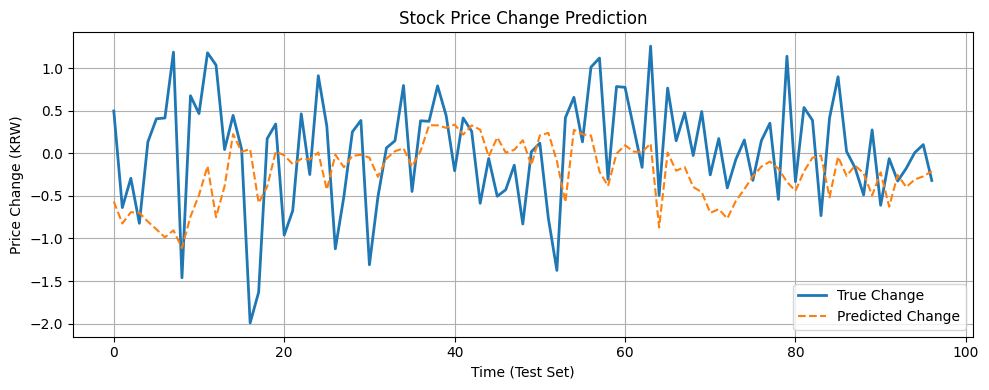

In [18]:
# ✅ 13. 예측 vs 실제 증가량 시각화
plt.figure(figsize=(10, 4))
plt.plot(y_true, label="True Change", linewidth=2)
plt.plot(y_pred, label="Predicted Change", linestyle='--')
plt.title("Stock Price Change Prediction")
plt.xlabel("Time (Test Set)")
plt.ylabel("Price Change (KRW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###Excercise 1
어떻게 성능을 향상 시킬 수 있을까?

1. Hyperparameter 조정
  - epoch
  - learning rate
  - Loss?
2. Model architecture 조정
  - num of layers
  - dim of layers

In [19]:
# ✅ 회귀 모델 정의

# 1. 만약 Layer의 개수가 4개라면?
# 2. 만약 hidden state의 dim이 64라면?
class StockRegressor(nn.Module):
    def __init__(self, input_dim):
        super(StockRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # 회귀는 출력이 1개
        )

    def forward(self, x):
        return self.model(x)

modified_model = StockRegressor(input_dim=3)

In [ ]:
# ✅ 학습 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
epochs = 500

In [ ]:
# ✅ 학습 루프
for epoch in range(epochs):
    modified_model.train()
    preds = model(X_train)
    loss = criterion(preds, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {loss.item():.6f}")

In [ ]:
# ✅ 평가
modified_model.eval()
y_pred_scaled = model(X_test).detach().numpy()
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test.numpy())
with torch.no_grad():
    y_pred = modified_model(X_test).numpy()
    y_true = y_test.numpy()

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)


    print(f"\n📊 MSE: {mse:.4f}")
    print(f"📊 MAE: {mae:.4f}")

In [ ]:
# ✅ 예측 vs 실제 증가량 시각화
plt.figure(figsize=(10, 4))
plt.plot(y_true, label="True Change", linewidth=2)
plt.plot(y_pred, label="Predicted Change", linestyle='--')
plt.title("Stock Price Change Prediction")
plt.xlabel("Time (Test Set)")
plt.ylabel("Price Change (KRW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()